# Import Modules

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import movingpandas as mpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
# import torch

import scipy
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import scipy.stats

# Load Data

## Version 1: Using movingpandas

In [2]:
# Set the filename
# filename = '../data/SharkArray-2020-05-21-thru-05-28.csv'
filename = '../data/2020-19-max-3-min-run.csv'

# Load shark positions data into a GeoDataFrame
shark_gdf = pd.read_csv(filename)
shark_gdf['t'] = pd.to_datetime(shark_gdf['DATETIME'])
shark_gdf['geometry'] = gpd.points_from_xy(shark_gdf.LON, shark_gdf.LAT)
shark_gdf = gpd.GeoDataFrame(shark_gdf)
shark_gdf = shark_gdf.set_crs('EPSG:4326')
shark_gdf = shark_gdf.set_index('t').tz_localize(None)
shark_gdf.head(3)

,Unnamed: 0,TRANSMITTER,DETECTEDID,DATETIME,X,Y,D,LAT,LON,n,HPE,HPEm,TEMP,DEPTH,ACCEL,DRX,URX,geometry
t,,,,,,,,,,,,,,,,,,
2020-05-27 02:11:00,1114,2020-19,A69-9006-7851,5/27/2020 2:11,4962.24,5257.59,-0.607,34.401411,-119.549619,4,3.5,NaN,NaN,-0.6065,NaN,In_D Off_D Off_E OS2,In_D Off_D Off_E OS2,POINT (-119.54962 34.40141)
2020-05-27 02:12:00,1115,2020-19,A69-9006-7851,5/27/2020 2:12,4942.44,5299.11,-0.607,34.401785,-119.549834,1,6.0,NaN,NaN,-0.6065,NaN,In_D Off_D OS2,In_D Off_D OS2,POINT (-119.54983 34.40178)
2020-05-27 02:14:00,1116,2020-19,A69-9006-7851,5/27/2020 2:14,4923.17,5348.19,-0.607,34.402228,-119.550044,3,3.0,NaN,NaN,-0.6065,NaN,In_D In_E Off_D Off_E,In_D In_E Off_D Off_E,POINT (-119.55004 34.40223)


In [3]:
print('The dataset contains', shark_gdf.shape[0], 'rows and', shark_gdf.shape[1], 'columns.')
print('The column names are:', list(shark_gdf.columns.values))
print('The unique transmitter names are:', shark_gdf['TRANSMITTER'].unique())

The dataset contains 84 rows and 18 columns.
The column names are: ['Unnamed: 0', 'TRANSMITTER', 'DETECTEDID', 'DATETIME', 'X', 'Y', 'D', 'LAT', 'LON', 'n', 'HPE', 'HPEm', 'TEMP', 'DEPTH', 'ACCEL', 'DRX', 'URX', 'geometry']
The unique transmitter names are: ['2020-19']


In [4]:
# Create separate trajectories for each shark based on their transmitter ID
traj = mpd.TrajectoryCollection(shark_gdf, 'TRANSMITTER').trajectories[0]
print(traj)

Trajectory 2020-19 (2020-05-27 01:42:00 to 2020-05-27 03:28:00) | Size: 81 | Length: 1663.9m
Bounds: (-119.551802, 34.399479, -119.54474, 34.405934)
LINESTRING (-119.544833 34.399499, -119.544894 34.399509, -119.544824 34.399618, -119.544802 34.3996


In [5]:
# # Get number of points in each trajectory
# data = []
# for traj in traj_collection:
#     data.append([traj.id.split('_')[0], traj.df.shape[0]])
# num_points = pd.DataFrame(data, columns=['TRANSMITTER', 'NUM_POSITIONS'])
# print(num_points)

In [6]:
# Add a timedelta column which is the time between the previous position and the current position
n = traj.df.shape[0]
timedeltas = [timedelta()] + [traj.df.index[i] - traj.df.index[i - 1] for i in range(1, n)]
traj.df['TIMEDELTA'] = timedeltas

In [7]:
# Add velocities and headings to each trajectory
traj.add_speed()
traj.add_direction()

Text(0.5, 1.0, 'Longest 3-min run trajectory')

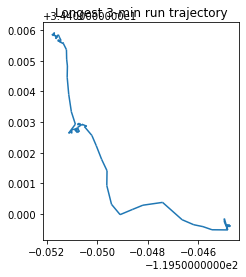

In [8]:
traj.plot(linestyle='None')
plt.title('Longest 3-min run trajectory')

### Compute turning angles

In [9]:
# Wrap angles (in degrees)
def bound_angle_diff(theta_diff):
    return ((theta_diff - 180) % 360) - 180

n = traj.df.shape[0]
turning_angles = [0] + [bound_angle_diff(traj.df['direction'][i + 1] - traj.df['direction'][i]) for i in range(1, n - 1)] + [0]

# Add turning angle to dataframe 
traj.df['turning_angle'] = turning_angles

### Plots: Turning Angle & Speed

Text(0, 0.5, 'counts')

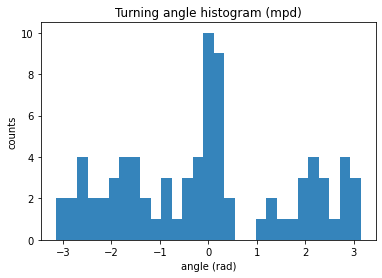

In [10]:
turning_angles = np.radians(np.array(traj.df['turning_angle']))
# turning_angles = tfd.VonMises(loc=-1, concentration=0).sample([207]).numpy()

# print(turning_angles)

plt.hist(turning_angles, bins=np.linspace(-np.pi, np.pi, 30), alpha=0.9)
plt.title('Turning angle histogram (mpd)')
plt.xlabel('angle (rad)')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

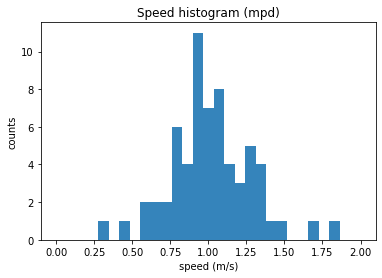

In [11]:
speeds = np.array(traj.df['speed'])
# print(speeds, len(speeds))

plt.hist(speeds, bins=np.linspace(0, np.ceil(np.max(speeds)), 30), alpha=0.9)
plt.title('Speed histogram (mpd)')
plt.xlabel('speed (m/s)')
plt.ylabel('counts')

### Plot trajectory with basemap 

In [11]:
# Import conntextily for basemap
import contextily as ctx

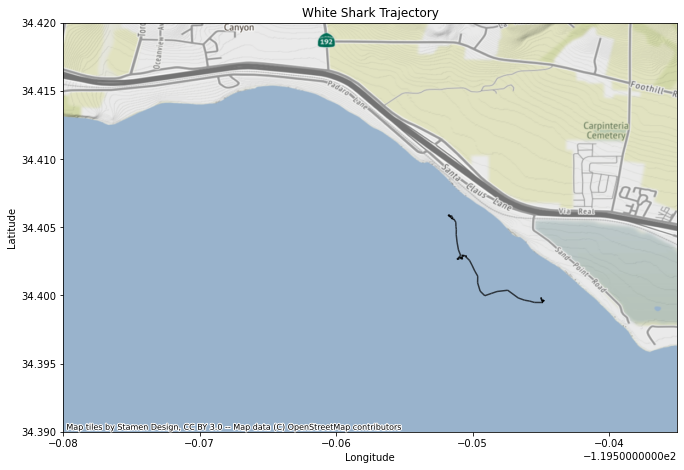

In [13]:
# Set bounds for plotting the shark data
west, south, east, north = (-119.58, 34.39, -119.535, 34.42)

# Set x and y limit, based on updated bounds
xlim = ([west, east])
ylim = ([south,  north])

# Use the plot() method to plot the points of one shark
ax_shark = traj.plot(figsize=(11, 8), alpha=0.7, color='black')

# # On the same axis, plot the other shark's points
# shark19.plot(ax=ax_shark, alpha=0.5, edgecolor='k')
# shark21.plot(ax=ax_shark, alpha=0.5, edgecolor='k')

# Set axes limits
ax_shark.set_xlim(xlim)
ax_shark.set_ylim(ylim)

# Add a basemap 
ctx.add_basemap(ax_shark, 
                crs=shark_gdf.crs.to_string(),
                source=ctx.providers.Stamen.Terrain)

# Add a legend and axis labels
# ax_shark.legend(["shark20", "shark19", "shark21"])
ax_shark.set_ylabel("Latitude")
ax_shark.set_xlabel("Longitude")
ax_shark.set_title("White Shark Trajectory")

# ax_shark.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))

# ax_shark.axis("equal")
ax_shark.grid(False)

plt.show(ax_shark)

In [ ]:
traj

## Version 2: Without movingpandas

This section relies on methods written by Alberto P. Soto

In [ ]:
# import sys
# sys.path.append('/Users/A_Soto/Documents/MATLAB/GitHub/white_shark_chrisH/scripts')
import white_shark as ws

### Import Data

In [ ]:
# Path to shark metadata 
TAGS_FILENAME = '../data/shark-acoustic-tags.csv'

# Call make_df from the main white_shark (ws) file
shark_df = ws.make_df(filename)

# print(shark_df.head())
tag_ids = ws.shark_meta(TAGS_FILENAME)

# Get metadata from unique shark IDs
uniq_ids = ws.match_shark_id(shark_df.TRANSMITTER, tag_ids)

# Create Shark objects of all unique sharks in dataset
shark_objs = ws.populate_sharks(shark_df, uniq_ids)

### Data Analysis 

#### Operations for every shark in dataset 

#### Within the for-loop we compute:
   1. delta T: time between consecutive observations
   2. step length: distance between consecutive observations
   3. turn angle: angle between consecutive position observations
   4. speed: needs delta T and step length 

In [ ]:
# Empty DataFrame for accumulating output data
output_df = pd.DataFrame()
frames = []

for fish in shark_objs:
    """ each fish object contains shark identifiers and its data (DataFrame)
    """

    # Compute delta_t, add to fish.data DataFrame as a new column
    fish.data["delta_t"] = ws.time_between_obs(fish)

    # Calculate step length, add to fish.data DataFrame as a new column
    fish.data["step_length"] = ws.calc_step_length(fish)
    
    # Calculate heading angle, add to fish.data DataFrame as a new column
    fish.data["heading_angle"] = ws.calc_heading_angle(fish)

    # Calculate turning angle, add to fish.data DataFrame as a new column
    fish.data["turn_angle"] = ws.calc_turn_angle(fish)

    # Calculate speed, add to fish.data DataFrame as a new column
    fish.data["speed"] = ws.calc_speed(fish)

    # Append current shark's output DataFrame to frames List
    frames.append(fish.data[["DATETIME", "delta_t", "step_length", "turn_angle", "speed"]])

# Concatenate all DataFrames in frames
df_out = pd.concat(frames)

# Set column names as headers
df_out.columns = ["DATETIME", "delta_t", "step_length", "turn_angle", "speed"]

# if "ALL" in POSITION_FILENAME:
#     cutoff = 720
# else:
#     cutoff = 60

In [ ]:
# check output
df_out.head()

#### Plots of turning angle and speed

In [ ]:
# turning_angles = np.radians(np.array(traj.df['turning_angle']))
# turning_angles = tfd.VonMises(loc=-1, concentration=0).sample([207]).numpy()

# print(turning_angles)

plt.hist(df_out['turn_angle'], bins=np.linspace(-np.pi, np.pi, 30), alpha=0.9)
plt.title('Turning angle histogram')
plt.xlabel('angle (rad)')
plt.ylabel('counts')

In [ ]:
plt.hist(df_out['speed'], bins=np.linspace(0, np.ceil(df_out['speed'].max()), 30), alpha=0.9)
plt.title('Speed histogram')
plt.xlabel('speed (m/s)')
plt.ylabel('counts')

In [ ]:
turnAngle = pd.DataFrame({'time': np.array(df_out.DATETIME), 
                          'turn_angle': np.array(df_out.turn_angle),
                          'turn_angle_mpd': np.array(turning_angles)})
turnAngle.set_index('time', inplace=True)
turnAngle.head()

In [ ]:
# plt.plot(turnAngle.DATETIME, turnAngle.turn_angle)
turnAngle.plot()
# np.array(df_out.DATETIME)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(turnAngle.turn_angle_mpd)
axs[1].plot(turnAngle.turn_angle)

#         ax.plot(x[:, 0], y[:, i], label=label)
#         ax.set_title(title)
#         ax.legend(loc='upper right')

# Helper Functions

In [12]:
def plot_state_posterior(ax, state_posterior_probs, observed_data, title, label='turning angles', ylabel='angle (rad)'):
    ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | angles)')
    ax.set_ylim(0., 1.1)
    ax.set_ylabel('posterior probability')
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_data, c='black', alpha=0.3, label=label)
    ax2.set_title(title)
    ax2.set_ylabel(ylabel)
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color='white')
    ax2.grid(False)

# fig, axs = plt.subplots(num_states, 1, figsize=(7, 5 * num_states))
# for state in range(num_states):
#     plot_state_posterior(axs[state], posterior_probs[:, state], turning_angles, 'state {} (mean turning angle {:.2f} rad)'.format(state, vm_locs[state]))

In [ ]:
# Save to csv with states
# traj.df.to_csv('../data/2020-21-max-3-min-run-{}-states.csv'.format(num_states), index=False)

# Sample Distributions 

## von Mises (loc = circular mean, concentration)

In [ ]:
# Plot some example von Mises distributions

num_vm = 1001

locs_vm = [2, 2, 0, 0]
cons_vm = [0, 2, 1, 4]

x = np.linspace(-np.pi, np.pi, num_vm).reshape(num_vm, 1)
y = tfd.VonMises(loc=locs_vm, concentration=cons_vm).prob(x).numpy()

for i in range(y.shape[1]):
    plt.plot(x[:, 0], y[:, i], label='loc={:.2f}, concentration={:.2f}'.format(locs_vm[i], cons_vm[i]))
plt.gca().set_ylim((0, 1))
plt.title('Von Mises examples')
plt.xlabel('angle (rad)')
plt.ylabel('probability density')
plt.legend()
plt.show()

## Gamma (concentration = $\alpha$, rate = $\beta$)

In [ ]:
# Plot some example gamma distributions

num_g = 1001

shapes_g = [1, 1, 1, 2, 2, 2]
rates_g = [2, 1, 0.5, 2, 1, 0.5]

x = np.linspace(0, 6, num_g).reshape(num_g, 1)
y = tfd.Gamma(concentration=shapes_g, rate=rates_g).prob(x).numpy()

for i in range(y.shape[1]):
    plt.plot(x[:, 0], y[:, i], label='shape={:.2f}, rate={:.2f}'.format(shapes_g[i], rates_g[i]))
plt.gca().set_xlim((0, 6))
plt.gca().set_ylim((0, np.max(y)))
plt.title('Gamma examples')
plt.xlabel('speed (m/s)')
plt.ylabel('probability density')
plt.legend()
plt.show()

# 2-state Hidden Markov Model

## Observations: Turning Angle & Speed

## Set up probability distributions and HMM structure

In [13]:
# Create a random generator
rng = np.random.default_rng()

In [14]:
# We assume 2 states
num_states = 2

# Randomly initialize the initial state distriubtion as well as the transition probabilities
initial_probs = tf.Variable(scipy.special.softmax(rng.random([num_states])), name='initial_probs')
transition_probs = tf.Variable(scipy.special.softmax(rng.random([num_states, num_states]), axis=1), name='transition_probs')

print("Initial state probs:\n{}".format(initial_probs))
print("Transition matrix:\n{}".format(transition_probs))

Initial state probs:
<tf.Variable 'initial_probs:0' shape=(2,) dtype=float64, numpy=array([0.45008459, 0.54991541])>
Transition matrix:
<tf.Variable 'transition_probs:0' shape=(2, 2) dtype=float64, numpy=
array([[0.65787659, 0.34212341],
       [0.49201051, 0.50798949]])>


In [15]:
# Initialize locations and concentrations of Von Mises distributions for turning angles
# vm_locs = tf.Variable(np.zeros(num_states))
# vm_cons = tf.Variable(np.zeros(num_states))
vm_locs = tf.Variable(rng.random(num_states))
vm_cons = tf.Variable(rng.random(num_states)) 

# Initialize shapes and rates of Gamma distributions for speed
# gamma_shapes = tf.Variable(np.ones(num_states))
# gamma_rates = tf.Variable(np.ones(num_states))
gamma_shapes = tf.Variable(rng.random(num_states))
gamma_rates = tf.Variable(rng.random(num_states))

# joint_dists = tfd.JointDistributionSequential([
#     tfd.VonMises(loc=vm_locs, concentration=vm_cons),
#     tfd.Gamma(concentration=gamma_shapes, rate=gamma_rates)
# ])

joint_dists = tfd.Blockwise([
    tfd.VonMises(loc=vm_locs, concentration=vm_cons),
    tfd.Gamma(concentration=gamma_shapes, rate=gamma_rates)
])

print('von Mises locations:\n{}'.format(vm_locs))
print('von Mises concentrations:\n{}'.format(vm_cons))
print('Gamma shapes:\n{}'.format(gamma_shapes))
print('Gamma rates:\n{}'.format(gamma_rates))
print(joint_dists)

von Mises locations:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([0.94090016, 0.89059247])>
von Mises concentrations:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([0.86548275, 0.94419838])>
Gamma shapes:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([0.67132445, 0.87758457])>
Gamma rates:
<tf.Variable 'Variable:0' shape=(2,) dtype=float64, numpy=array([0.46515333, 0.05448983])>
tfp.distributions.Blockwise("Blockwise", batch_shape=[2], event_shape=[2], dtype=float64)


## Print initial values

In [16]:
 print("Initial probs: {}\nTransition probs:\n{}\nVon Mises locs: {}\nVon Mises cons: {}\nGamma shapes: {}\nGamma rates: {}\n".format(initial_probs.numpy(), 
                                                                                                                                     transition_probs.numpy(), 
                                                                                                                                     vm_locs.numpy(), 
                                                                                                                                     vm_cons.numpy(), 
                                                                                                                                     gamma_shapes.numpy(), 
                                                                                                                                     gamma_rates.numpy()))

Initial probs: [0.45008459 0.54991541]
Transition probs:
[[0.65787659 0.34212341]
 [0.49201051 0.50798949]]
Von Mises locs: [0.94090016 0.89059247]
Von Mises cons: [0.86548275 0.94419838]
Gamma shapes: [0.67132445 0.87758457]
Gamma rates: [0.46515333 0.05448983]



In [17]:
# Create HMM
hmm2 = tfd.HiddenMarkovModel(
    initial_distribution = tfd.Categorical(probs=initial_probs),
    transition_distribution = tfd.Categorical(probs=transition_probs),
    observation_distribution = joint_dists,
    num_steps = len(turning_angles)
)

In [ ]:
# hmm2 = tfd.HiddenMarkovModel()

## Set log probabilities from input data

In [ ]:
hmm2.log_prob(np.array([turning_angles, speeds]).T)

In [18]:
# Define a loss function
def log_prob():
    return tf.reduce_logsumexp(hmm2.log_prob(np.array([turning_angles, speeds]).T))

# Define an optimizer to perform back propagation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Make sure probabilities sum to 1
def normalize_probs(probs):
    abs_probs = tf.math.abs(probs)
    if len(probs.shape) > 1:
        sums = tf.reshape(tf.reduce_sum(abs_probs, axis=1), [probs.shape[0], 1])
    else:
        sums = tf.reduce_sum(abs_probs)
    return abs_probs / sums

def wrap_to_pi(A):
    return ((A - np.pi) % (2 * np.pi) - np.pi)

# Run a step of the optimizer
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    vars = [initial_probs, transition_probs, vm_locs, vm_cons, gamma_shapes, gamma_rates]
    grads = tape.gradient(neg_log_prob, vars)
    optimizer.apply_gradients(zip(grads, vars))
    initial_probs.assign(normalize_probs(initial_probs))
    transition_probs.assign(normalize_probs(transition_probs))
    vm_locs.assign(wrap_to_pi(vm_locs))
    vm_cons.assign(tf.math.abs(vm_cons))
    gamma_shapes.assign(tf.math.abs(gamma_shapes))
    gamma_rates.assign(tf.math.abs(gamma_rates))
    return (neg_log_prob, *vars), grads

In [19]:
# Train on the observations
loss_history = []
for step in range(1000):
    ts, grads = train_op()
    loss, ip, tp, vl, vc, gs, gr = [t.numpy() for t in ts]
    loss_history.append(loss)
    if step % 40 == 0:
        print("step {}: log prob {}\nInitial probs: {}\nTransition probs:\n{}\nVon Mises locs: {}\nVon Mises cons: {}\nGamma shapes: {}\nGamma rates: {}\n".format(step, -loss, ip, tp, vl, vc, gs, gr))

step 0: log prob -212.3611070207934
Initial probs: [0.55008413 0.44991587]
Transition probs:
[[0.75787658 0.24212342]
 [0.59201044 0.40798956]]
Von Mises locs: [0.84090017 0.79059255]
Von Mises cons: [0.76548284 0.84419975]
Gamma shapes: [0.77132444 0.77758459]
Gamma rates: [0.56515332 0.15448982]

step 40: log prob -111.69203021922523
Initial probs: [0.95019001 0.04980999]
Transition probs:
[[0.95406245 0.04593755]
 [0.96877052 0.03122948]]
Von Mises locs: [-0.16110957 -0.22968013]
Von Mises cons: [1.83001479 1.91537378]
Gamma shapes: [3.59549765 1.34275455]
Gamma rates: [3.37538246 0.89701036]

step 80: log prob -103.26530545111326
Initial probs: [0.95411604 0.04588396]
Transition probs:
[[0.95259396 0.04740604]
 [0.96340833 0.03659167]]
Von Mises locs: [-0.09405627 -0.1337574 ]
Von Mises cons: [1.86471672 2.72487673]
Gamma shapes: [5.11007338 1.46639732]
Gamma rates: [4.88521811 1.11228813]

step 120: log prob -98.87620243778089
Initial probs: [0.96727997 0.03272003]
Transition prob

In [20]:
print("step {}: log prob {}\nInitial probs: {}\nTransition probs:\n{}\nVon Mises locs: {}\nVon Mises cons: {}\nGamma shapes: {}\nGamma rates: {}\n".format(step, -loss, ip, tp, vl, vc, gs, gr))

step 999: log prob -85.48798077630718
Initial probs: [0.06345607 0.93654393]
Transition probs:
[[0.83595223 0.16404777]
 [0.97157181 0.02842819]]
Von Mises locs: [-0.10231512 -0.10401059]
Von Mises cons: [ 1.61756649 43.79397581]
Gamma shapes: [15.92609239  6.00293534]
Gamma rates: [15.65322084  5.85243289]



## Plot results and inferred states

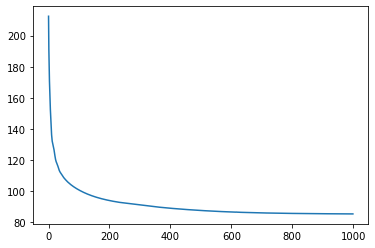

In [21]:
plt.plot(loss_history)

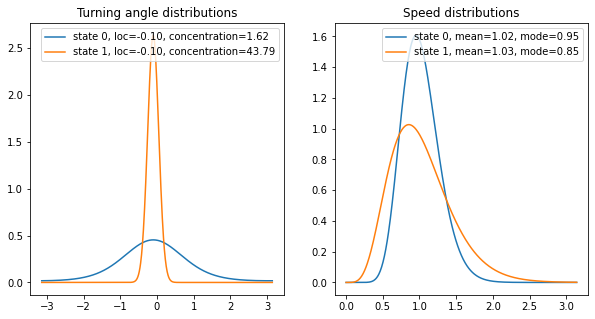

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot observation distributions
num = 1001
x = np.linspace(-np.pi, np.pi, num).reshape(num, 1)
for (j, (obs_dist, ax)) in enumerate(zip(hmm2.observation_distribution.distributions, axs)):
    y = obs_dist.prob(x).numpy()
    for i in range(y.shape[1]):
        if j == 0:
            label = 'state {}, loc={:.2f}, concentration={:.2f}'.format(i, vm_locs[i], vm_cons[i])
            title = 'Turning angle distributions'
        else:
            label = 'state {}, mean={:.2f}, mode={:.2f}'.format(i, gamma_shapes[i] / gamma_rates[i], (gamma_shapes[i] - 1) / gamma_rates[i])
            title = 'Speed distributions'
        ax.plot(x[:, 0], y[:, i], label=label)
        ax.set_title(title)
        ax.legend(loc='upper right')
# fig.suptitle('Emission probability distributions')
# axs[0].set_title('Emission probability distributions')
plt.show()

In [23]:
posterior_dists = hmm2.posterior_marginals(np.array([turning_angles, speeds]).T)
posterior_probs = posterior_dists.probs_parameter().numpy()

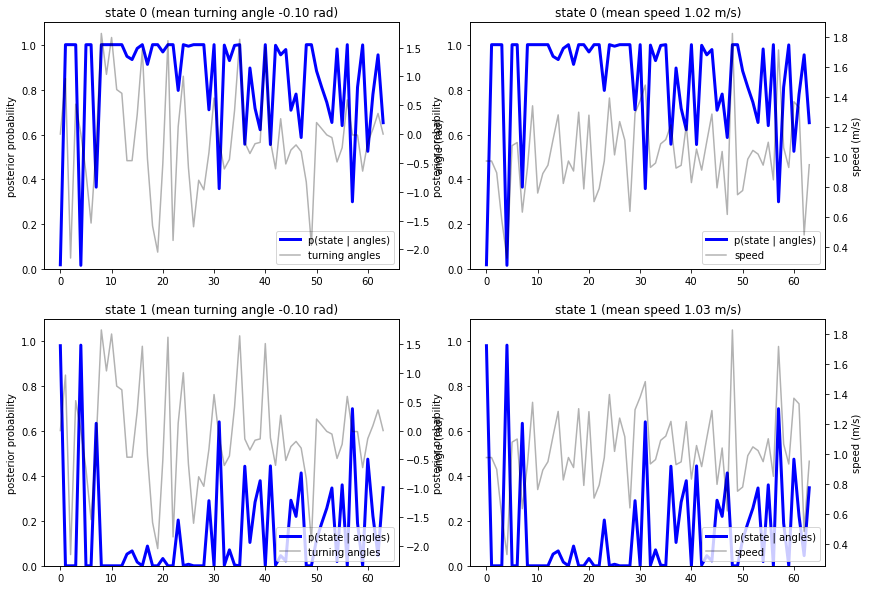

In [24]:
fig, axs = plt.subplots(num_states, 2, figsize=(14, 5 * num_states))
for state, ax_row in enumerate(axs):
    for i, ax in enumerate(ax_row):
        if i == 0:
            plot_state_posterior(ax, posterior_probs[:, state], turning_angles, 'state {} (mean turning angle {:.2f} rad)'.format(state, vm_locs[state]))
        else:
            plot_state_posterior(ax, posterior_probs[:, state], speeds, 'state {} (mean speed {:.2f} m/s)'.format(state, gamma_shapes[state] / gamma_rates[state]), label='speed', ylabel='speed (m/s)')

Text(0.5, 1.0, 'Trajectory with states')

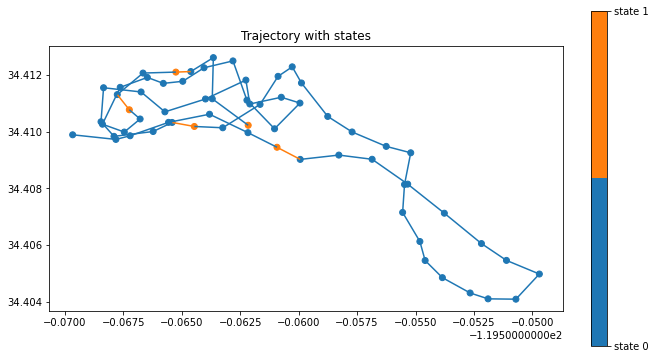

In [25]:
x = [point.coords[0][0] for point in traj.df['geometry']]
y = [point.coords[0][1] for point in traj.df['geometry']]
fig, ax = plt.subplots(figsize=(10, 10))
cmaplist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'][:num_states]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, num_states)
color = np.argmax(posterior_probs, axis=1)
sc = ax.scatter(x, y, c=color, cmap=cmap)
traj.df['state'] = color
traj.plot(ax=ax, marker='o', column='state', cmap=cmap)
ticks = np.array(list(range(num_states)))
tick_labels = ['state {}'.format(i) for i in range(num_states)]
cbar = plt.colorbar(sc, fraction=0.03)
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
plt.title('Trajectory with states')

In [ ]:
# Save to csv with states
traj.df.to_csv('../data/2020-13-max-3-min-run-{}-states-with-speeds.csv'.format(num_states), index=False)

## Sample from HMM

In [ ]:
def get_sample_traj(sampled_obs, traj):
    '''
    Converts a sample from an HMM to a trajectory
    '''
    # Bound angles to [-pi, pi]
    def wrap_to_pi(theta):
        return ((theta - 180) % 360) - 180
    
    # Convert sampled observations to x and y positions
    sampled_x = [0]
    sampled_y = [0]
    sampled_angle = [0]
    sampled_turning_angle = [sampled_obs[0][0]]
    sampled_speed = [sampled_obs[1][0]]
    times = np.array([dt.total_seconds() for dt in traj.df['TIMEDELTA']])
    for i, (dt, (turning_angle, speed)) in enumerate(zip(times, sampled_obs)):
        prev_x = sampled_x[i]
        prev_y = sampled_y[i]
        prev_angle = sampled_angle[i]
        step_length = dt * speed
        angle = wrap_to_pi(prev_angle + turning_angle)
        x = step_length * np.cos(angle) + prev_x
        y = step_length * np.sin(angle) + prev_y
        sampled_x.append(x)
        sampled_y.append(y)
        sampled_angle.append(angle)
        sampled_turning_angle.append(turning_angle)
        sampled_speed.append(speed)
    
    # Align the samples' centroids and make them the same scale
    sampled_x = np.array(sampled_x)
    sampled_y = np.array(sampled_y)
    avg_x = np.average(sampled_x)
    avg_y = np.average(sampled_y)
    sampled_x -= avg_x
    sampled_y -= avg_y
    actual_x = []
    actual_y = []
    for point in traj.df['geometry']:
        x, y = point.coords[0]
        actual_x.append(x)
        actual_y.append(y)
    actual_x = np.array(actual_x)
    actual_y = np.array(actual_y)
    avg_x = np.average(actual_x)
    avg_y = np.average(actual_y)
    actual_range_x = np.max(actual_x) - np.min(actual_x)
    actual_range_y = np.max(actual_y) - np.min(actual_y)
    sampled_range_x = np.max(sampled_x) - np.min(sampled_x)
    sampled_range_y = np.max(sampled_y) - np.min(sampled_y)
    sampled_x *= actual_range_x / sampled_range_x
    sampled_y *= actual_range_y / sampled_range_y
    sampled_x += avg_x
    sampled_y += avg_y
    data = np.array([sampled_x, sampled_y, sampled_angle, sampled_turning_angle, sampled_speed])
    sample_traj = pd.DataFrame(data.T[1:], columns=['LON', 'LAT', 'direction', 'turning_angle', 'speed'])
    sample_traj['t'] = traj.df.index
    sample_traj['geometry'] = gpd.points_from_xy(sample_traj.LON, sample_traj.LAT)
    sample_traj = gpd.GeoDataFrame(sample_traj)
    sample_traj = sample_traj.set_crs('EPSG:4326')
    sample_traj = sample_traj.set_index('t').tz_localize(None)
    return mpd.Trajectory(sample_traj, traj.id + '-sampled')

In [ ]:
# Sample the HMM to get a path
sampled_obs = hmm2.sample().numpy()
sample_traj = get_sample_traj(sampled_obs, traj)

In [ ]:
fig, ax = plt.subplots()
traj.plot(ax=ax, label='actual path', color='#1f77b4')
sample_traj.plot(ax=ax, label='sampled path', color='#ff7f0e')
plt.legend()

In [ ]:
plt.plot(traj.df['DEPTH'])

# HMM for Observation Counts

In [ ]:
# Set the filename
# filename = '../data/SharkArray-2020-05-21-thru-05-28.csv'
filename = '../data/SharkArray-01-animals.csv'

# Load shark positions data into a GeoDataFrame
shark_gdf = pd.read_csv(filename)
shark_gdf['t'] = pd.to_datetime(shark_gdf['DATETIME'])
shark_gdf['geometry'] = gpd.points_from_xy(shark_gdf.LON, shark_gdf.LAT)
shark_gdf = gpd.GeoDataFrame(shark_gdf)
shark_gdf = shark_gdf.set_crs('EPSG:4326')
shark_gdf = shark_gdf.set_index('t').tz_localize(None)
shark_gdf.head()

In [ ]:
print('The dataset contains', shark_gdf.shape[0], 'rows and', shark_gdf.shape[1], 'columns.')
print('The column names are:', list(shark_gdf.columns.values))
print('The unique transmitter names are:', shark_gdf['TRANSMITTER'].unique())

In [ ]:
# Create separate trajectories for each shark based on their transmitter ID
traj_collection = mpd.TrajectoryCollection(shark_gdf, 'TRANSMITTER')
print(traj_collection)

In [ ]:
# Count number of data points for each hour
total_counts = []

for i, traj in enumerate(traj_collection.trajectories):
    start_time = traj.df.index.min()
    end_time = traj.df.index.max()
    delta = end_time - start_time
    num_bins = max(int(delta.total_seconds() // (3600)), 1)
    counts = np.histogram(
        np.array([(traj.df.index[i] - start_time).total_seconds() for i in range(traj.size())]) // (3600), 
        num_bins,
        range=(0, num_bins)
    )[0]
    print('{}: Start time = {}, number of bins = {}, number of 0 counts = {}'.format(i, start_time, num_bins, np.sum(counts == 0)))
    total_counts.append(counts)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(total_counts[9])
# ax.set_xlim((0, 100))

In [ ]:
# We assume 2 states
num_states = 2

# Randomly initialize the initial state distriubtion as well as the transition probabilities
initial_probs = tf.Variable(scipy.special.softmax(rng.random([num_states])), name='initial_probs')
transition_probs = tf.Variable(scipy.special.softmax(rng.random([num_states, num_states]), axis=1), name='transition_probs')

print("Initial state probs:\n{}".format(initial_probs))
print("Transition matrix:\n{}".format(transition_probs))

In [ ]:
# Plot some example poisson distributions
num = 1001
rates = [0, 1, 2, 3]
x = np.linspace(0, 6, num).reshape(num, 1)
# x = np.arange(0, 10).reshape(-1, 1)
y = tfd.Poisson(rate=rates).prob(x).numpy()
for i in range(y.shape[1]):
    plt.plot(x[:, 0], y[:, i], label='rate={:.2f}'.format(rates[i]))
plt.gca().set_xlim((0, 6))
plt.gca().set_ylim((0, np.max(y)))
plt.title('Poisson examples')
plt.xlabel('counts')
plt.ylabel('probability density')
plt.legend()
plt.show()

In [ ]:
# Initialize rates of Poisson distributions for counts
poisson_rates = tf.Variable(np.ones(num_states))
print('Poisson rates:\n{}'.format(poisson_rates))

In [ ]:
counts = total_counts[0]
print(counts)

In [ ]:
# Create HMM
hmm3 = tfd.HiddenMarkovModel(
    initial_distribution = tfd.Categorical(probs=initial_probs),
    transition_distribution = tfd.Categorical(probs=transition_probs),
    observation_distribution = tfd.Poisson(rate=poisson_rates),
    num_steps = len(counts)
)

In [ ]:
hmm3.log_prob(counts)

In [ ]:
# Define a loss function
def log_prob():
    return tf.reduce_logsumexp(hmm3.log_prob(counts))

# Define an optimizer to perform back propagation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# Make sure probabilities sum to 1
def normalize_probs(probs):
    abs_probs = tf.math.abs(probs)
    if len(probs.shape) > 1:
        sums = tf.reshape(tf.reduce_sum(abs_probs, axis=1), [probs.shape[0], 1])
    else:
        sums = tf.reduce_sum(abs_probs)
    return abs_probs / sums

# Run a step of the optimizer
@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    vars = [initial_probs, transition_probs, poisson_rates]
    grads = tape.gradient(neg_log_prob, vars)
    optimizer.apply_gradients(zip(grads, vars))
    initial_probs.assign(normalize_probs(initial_probs))
    transition_probs.assign(normalize_probs(transition_probs))
    poisson_rates.assign(tf.math.abs(poisson_rates))
    return (neg_log_prob, *vars), grads

In [ ]:
# Train on the observations
loss_history = []
for step in range(200):
    ts, grads = train_op()
    loss, ip, tp, pr = [t.numpy() for t in ts]
    loss_history.append(loss)
    if step % 20 == 0:
        print("Grads:", *["\n{}".format(g.numpy()) for g in grads])
        print("step {}: log prob {}\nInitial probs: {}\nTransition probs:\n{}\nPoisson rates: {}\n".format(step, -loss, ip, tp, pr))

In [ ]:
plt.plot(loss_history)

In [ ]:
# Plot Poisson distributions
num = 1001
x = np.linspace(0, 50, num).reshape(num, 1)
y = hmm3.observation_distribution.prob(x).numpy()
for i in range(y.shape[1]):
    plt.plot(x[:, 0], y[:, i], label='state {}, rate={:.2f}'.format(i, poisson_rates[i]))
plt.gca().set_ylim((0, 1))
plt.title('Emission probability distributions')
plt.xlabel('counts')
plt.ylabel('probability density')
plt.legend()
plt.show()

In [ ]:
posterior_dists = hmm3.posterior_marginals(counts)
# posterior_probs = posterior_dists.probs_parameter().numpy()

In [ ]:
fig, axs = plt.subplots(num_states, 1, figsize=(7, 5 * num_states))
for state in range(num_states):
    plot_state_posterior(axs[state], posterior_probs[:, state], turning_angles, 'state {} (mean turning angle {:.2f} rad)'.format(state, vm_locs[state]))